# Notebook Outline

This notebook implements an end‐to‐end pipeline for classifying short video clips of customers as **happy** or **angry**. Below is a high‐level description of each cell, so you know what to expect and where to find each step.

---

1. **Cell 1: Imports & Environment Setup**  
   - Import essential Python libraries (e.g., PyTorch, OpenCV, sklearn, pandas, matplotlib).  
   - Check which device (CPU/GPU) PyTorch will use.

2. **Cell 2: Verify Working Directory**  
   - Print the current working directory (should be the `Video/` folder).  
   - Optionally, change directory if needed.

3. **Cell 3: Generate `labels.csv`**  
   - Scan `Video/Happy/` and `Video/Angry/` sub‐folders for `.mp4` or `.avi` files.  
   - Build a Pandas DataFrame with two columns: `filepath` and `label` (“happy” or “angry”).  
   - Save this as `labels.csv` and print a preview + class counts to confirm (21 happy, 21 angry).

4. **Cell 4: Split Data into Train / Validation / Test Sets**  
   - Load `labels.csv` into a DataFrame.  
   - Perform a stratified 80%/10%/10% split using `train_test_split`, preserving a 1:1 happy:angry ratio.  
   - Print the shapes and label counts for `train_df`, `val_df`, and `test_df`.

5. **Cell 5: Create the `VideoDataset` & DataLoaders**  
   - Define a custom PyTorch `VideoDataset` class that:  
     1. Samples exactly 10 frames from the last 5 seconds of each video (or the full clip if <5 s).  
     2. Resizes each frame to 224×224 and normalises it to ImageNet statistics.  
     3. Returns a tensor of shape `(10, 3, 224, 224)` plus an integer label index (`0` for angry, `1` for happy).  
   - Instantiate `VideoDataset(train_df)`, `VideoDataset(val_df)`, and `VideoDataset(test_df)`.  
   - Wrap each dataset in a `DataLoader(batch_size=4, num_workers=0)` for training, validation, and testing.  
   - Print the number of batches in each loader and sanity‐check one batch’s shape.

6. **Cell 6: Define CNN + LSTM Model, Loss Function, and Optimizer**  
   - Create the `CNN_LSTM_Classifier` class:  
     - Load MobileNetV2 (pretrained on ImageNet) and freeze its convolutional backbone.  
     - Apply an adaptive average‐pool to get a 1280‐d feature vector per frame.  
     - Feed the sequence of 10 features into an `nn.LSTM(input_size=1280, hidden_size=256)`.  
     - Use a final `nn.Linear(256 → 2)` to produce logits for “angry” vs “happy.”  
   - Instantiate the model, move it to `device`, and print its architecture.  
   - Define `criterion = nn.CrossEntropyLoss()` and `optimizer = torch.optim.Adam(...)`, updating only the LSTM and FC layers.  
   - Print the number of trainable parameters.

7. **Cell 7: Train the Model (Training & Validation Loop)**  
   - Loop for a fixed number of epochs (e.g., 5).  
   - In each epoch:  
     1. **Training:** set `model.train()`, iterate over `train_loader`, forward‐pass, compute loss, backpropagate, and update the LSTM + FC. Accumulate training loss and compute epoch training accuracy.  
     2. **Validation:** set `model.eval()`, iterate over `val_loader` under `torch.no_grad()`, forward‐pass, compute validation loss, and compute epoch validation accuracy.  
     3. Print a summary:  
        ```
        Epoch {epoch}/{n_epochs}  
          Train Loss: {train_loss:.4f}   Train Acc: {train_acc:.3f}  
          Val   Loss: {val_loss:.4f}     Val   Acc: {val_acc:.3f}
        ```  
     4. If the current `val_acc` exceeds **best_val_acc**, update `best_val_acc` and save the model state to `"cnn_lstm_best_val.pth"`.  
   - After training, plot side-by-side curves of train/val loss and train/val accuracy over epochs.  
   - Print the **final** validation accuracy, the **best** validation accuracy, and the path to the saved best-val model.

8. **Cell 8: Inference on TestSet Using Best‐Val Model**  
   - **Reload the Best‐Val Model**  
     - Instantiate the same `CNN_LSTM_Classifier` architecture.  
     - Load the checkpoint `cnn_lstm_best_val.pth` (the model weights that achieved the highest validation accuracy).  
     - Move the model to `device` (CPU or GPU) and set it to `eval()` mode.  
   - **Build a DataFrame of Test Clips**  
     - Scan the folders `TestSet/Happy/` and `TestSet/Angry/` for any `.mp4` or `.avi` files.  
     - Create a DataFrame `df_testser` with two columns:  
       - `filepath`: full path to each video file (forward-slash formatted).  
       - `label`: `"happy"` or `"angry"`, inferred from the parent folder name.  
     - Print out the first few rows and class counts to confirm that all test videos have been located correctly.  
   - **Define `VideoDatasetInference`**  
     - This dataset class mirrors our training-time `VideoDataset` but is used for inference. For each clip, it:  
       1. Opens the video with OpenCV.  
       2. Computes `total_frames` and `fps`.  
       3. Identifies the indices corresponding to the last 5 seconds (or the entire clip if it’s shorter).  
       4. Uniformly samples exactly 10 frames within that window.  
       5. Converts each BGR frame to RGB, wraps it as a PIL image, and applies the same `transform` (resize → 224×224 → normalise).  
       6. If fewer than 10 frames are read (e.g., clip < 10 frames or a read failure), pads by repeating the last valid frame.  
       7. Returns a tensor of shape `(10, 3, 224, 224)` plus the integer label index (`0` for “angry,” `1` for “happy”).  
   - **Create the Inference Dataset & DataLoader**  
     - Instantiate `inference_dataset = VideoDatasetInference(df_testser, n_frames=10, sample_last_secs=5, transform=transform)`.  
     - Wrap it in a `DataLoader` with `batch_size=1` (to visualise each clip individually) and `num_workers=0` (to avoid multiprocessing issues).  
   - **Prepare to Save Figures**  
     - Define `pdf_path = "test_results.pdf"` and create a folder `test_results_png/` to hold individual PNG exports.  
     - Open a `with PdfPages(pdf_path) as pdf:` context so that each call to `pdf.savefig(fig)` appends a new page.  
   - **Loop Over Test Clips & Perform Inference**  
     - Disable gradient computation with `torch.no_grad()`.  
     - For each clip (batch size = 1):  
       1. Move the clip tensor (shape `(1, 10, 3, 224, 224)`) to `device`.  
       2. Look up the ground-truth label string (`true_label`) from `inference_dataset.labels`.  
       3. Forward-pass through the loaded best-val `model` to get `logits` of shape `(1, 2)`.  
       4. Compute `pred_label = inference_dataset.labels[logits.argmax(dim=1).item()]`.  
       5. Take the first 5 of the 10 sampled frames, un-normalise them (map pixel values back to `[0, 1]`) and plot them side by side in a single figure with:  
          ```
          Clip {idx+1}: True = {true_label.upper()}  |  Pred = {pred_label.upper()}
          ```  
       6. Call `plt.show()` to display the figure inline in the notebook.  
       7. **(Optional)** Add new video clips of your own into `TestSet/Happy/` or `TestSet/Angry/` before running this cell—any clips placed in these folders will be automatically classified.  
   - **Save Each Figure**  
     - After displaying, call `pdf.savefig(fig)` to append the figure as a new page in `test_results.pdf`.  
     - Also save the figure as a PNG named  
       ```
       clip_{idx+1}_true_{true_label}_pred_{pred_label}.png
       ```  
       inside `test_results_png/`.  
     - Call `plt.close(fig)` to free memory.  
   - **Final Printouts**  
     - After processing all clips, print:  
       ```
       Saved multi-page PDF: <full_path>/test_results.pdf  
       Saved individual PNGs in folder: <full_path>/test_results_png
       ```  
     ---

**Usage Notes:**  
- Ensure your directory structure is exactly:

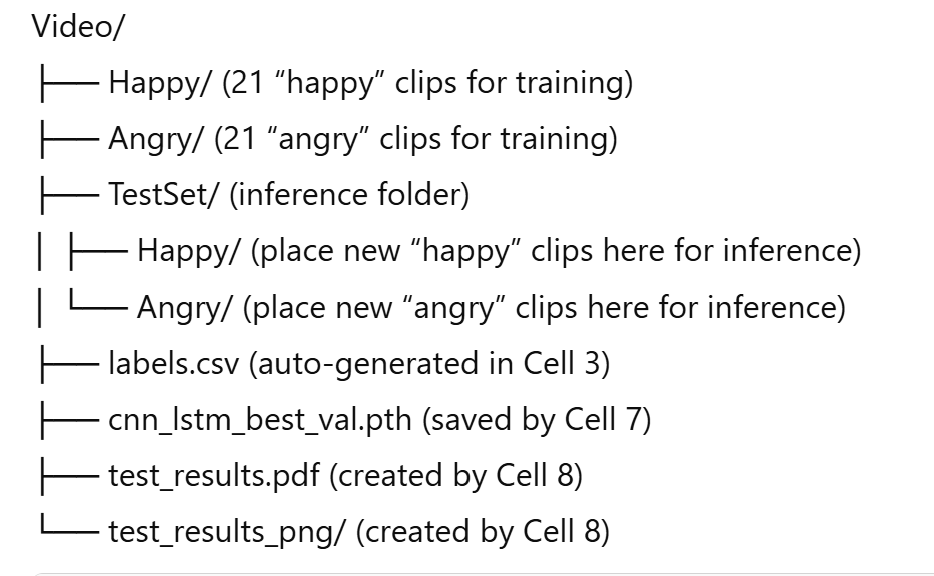

- Run each cell in order.  
- After Cell 7 completes, you will have:  
- Training/validation loss & accuracy curves displayed.  
- `cnn_lstm_best_val.pth` saved in the `Video/` folder.  
- Run Cell 8 only after training, since it requires `cnn_lstm_best_val.pth`.  

Good luck, and feel free to modify hyperparameters (e.g., `n_epochs`, LSTM hidden size) or data transforms to improve performance on your local machine!  



# Video‐Based Customer Sentiment Classification  
_A proof‐of‐concept: classifying “happy” vs “angry” customers from short video clips_

**Cell 1: Imports & Environment Setup**  
This cell imports all necessary libraries for data handling, model building, video processing, and visualization. It also checks whether a GPU is available, defaulting to CPU otherwise.


In [10]:
# 1. Imports & Environment Check
import os
import pandas as pd
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Optionally, check Torch device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


**Cell 2: Verify Working Directory**  
This cell prints the current working directory to confirm that we are in the `Video` folder. If it’s not correct, you can uncomment and adjust the `os.chdir(...)` line to change to the appropriate path before proceeding.


In [11]:
# 2. Verify Working Directory
cwd = os.getcwd()
print("Current directory:", cwd)
# If needed:
# os.chdir(r"C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Video")
# print("Changed directory to:", os.getcwd())


Current directory: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Video


## 3. Generated `labels.csv`

In the cell above, we:

1. **Scanned the `Happy/` and `Angry/` sub‐folders** in our working directory (`Video/Happy/` and `Video/Angry/`) to find every video file ending in `.mp4` or `.avi`.  
2. **Built a simple table (`labels.csv`)** where each row contains:
   - `filepath`: the full path to the video file (e.g. `C:/Users/IAGhe/…/Video/Happy/happy03.mp4`), and  
   - `label`: the class string (`"happy"` or `"angry"`), inferred from its parent folder name (converted to lowercase).  
3. **Saved this table** as `labels.csv` so that our downstream code can read it and know which clip belongs to which class, without any manual labeling.  

The printed output confirms that we have:
- 21 clips labelled `"happy"`, and
- 21 clips labelled `"angry"`,

for a total of 42 video files. This balanced `labels.csv` will let us perform a stratified train/validation/test split in the next step.```


## 3. Generated `labels.csv`

In this cell, we:

1. **Scan the `Happy/` and `Angry/` sub‐folders** in our working directory (`Video/Happy/` and `Video/Angry/`) to find every video file ending in `.mp4` or `.avi`.  
2. **Build a simple table (`labels.csv`)** where each row contains:
   - `filepath`: the full path to the video file (e.g. `C:/Users/IAGhe/…/Video/Happy/happy03.mp4`), and  
   - `label`: the class string (`"happy"` or `"angry"`), inferred from its parent folder name (converted to lowercase).  
3. **Save this table** as `labels.csv` so that our downstream code can read it and know which clip belongs to which class without any manual labeling.
When you run this code, you should see an output similar to: 
  
First 5 rows of labels.csv:
filepath label
0 C:/Users/IAGhe/.../Video/Happy/happy01.mp4 happy <br>
1 C:/Users/IAGhe/.../Video/Happy/happy02.mp4 happy <br>
2 C:/Users/IAGhe/.../Video/Happy/happy03.mp4 happy <br>
3 C:/Users/IAGhe/.../Video/Happy/happy04.mp4 happy <br>
4 C:/Users/IAGhe/.../Video/Happy/happy05.mp4 happy <br>

Counts per label: <br>
happy 21  <br>
angry 21  <br>
Name: count, dtype: int64  <br>
This confirms that we have 21 clips labelled `"happy"` and 21 clips labelled `"angry"`, for a total of 42 video files. A balanced `labels.csv` allows us to perform a stratified train/validation/test split in the next step.  


In [4]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell: Generate labels.csv from the "Happy" and "Angry" sub‐folders
# ────────────────────────────────────────────────────────────────────────────────

import os
import pandas as pd

# 1. List of class folder names (exactly as they appear in your working directory)
class_folders = ["Happy", "Angry"]

rows = []
for label in class_folders:
    folder_path = os.path.join(os.getcwd(), label)
    # Make sure the folder exists
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"Folder not found: {folder_path}")
    # Iterate over each file in that folder
    for fname in sorted(os.listdir(folder_path)):
        # Only consider video files (e.g. .mp4 or .avi)
        if fname.lower().endswith((".mp4", ".avi")):
            full_path = os.path.join(folder_path, fname).replace("\\", "/")
            rows.append({
                "filepath": full_path,
                "label": label.lower()   # store label as "happy" or "angry"
            })

# 2. Build a DataFrame and save to labels.csv
df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No video files found in 'Happy' or 'Angry' folders.")
df.to_csv("labels.csv", index=False)

# 3. Display the first few rows and counts per label to confirm
print("First 5 rows of labels.csv:")
print(df.head(), "\n")
print("Counts per label:")
print(df["label"].value_counts())


First 5 rows of labels.csv:
                                            filepath  label
0  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
1  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
2  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
3  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
4  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy 

Counts per label:
label
happy    21
angry    21
Name: count, dtype: int64


## 4. Split Data into Train / Validation / Test Sets

Now that we have a balanced `labels.csv` with 42 clips (21 happy, 21 angry), the next step is to divide them into three disjoint sets:

1. **Training set (80%)**  
   - Contains the majority of clips for learning model parameters (≈34 clips: 17 happy + 17 angry).  
2. **Validation set (10%)**  
   - Used to monitor performance during training and tune hyperparameters (≈4 clips: 2 happy + 2 angry).  
3. **Test set (10%)**  
   - Held out until the very end to give a final unbiased estimate of model performance (≈4 clips: 2 happy + 2 angry).

We perform a *stratified* split so that each subset maintains the same ratio of “happy” to “angry.” The code below uses scikit‐learn’s `train_test_split` twice. <br>
After running this cell, you should see something like:<br>
Train set shape: (34, 2) {'happy': 17, 'angry': 17}
Validation set shape: (4, 2) {'happy': 2, 'angry': 2}
Test set shape: (4, 2) {'happy': 2, 'angry': 2} <br>
This confirms an approximately 34/4/4 split with balanced classes.


In [5]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell: Perform an 80/10/10 stratified split of labels.csv
# ────────────────────────────────────────────────────────────────────────────────

import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load labels.csv
df = pd.read_csv("labels.csv")

# 2. First split: 80% train, 20% (validation + test)
train_df, valtest_df = train_test_split(
    df,
    test_size=0.20,           # 20% of 42 ≈ 8 clips
    stratify=df["label"],     # maintain the happy/angry ratio
    random_state=42
)

# 3. Second split: divide valtest_df (≈8 clips) equally into validation and test (4 each)
val_df, test_df = train_test_split(
    valtest_df,
    test_size=0.50,           # half of the 20% → 10% each
    stratify=valtest_df["label"],
    random_state=42
)

# 4. Verify the shapes and class balances
print("Train set shape:",     train_df.shape, train_df["label"].value_counts().to_dict())
print("Validation set shape:", val_df.shape,   val_df["label"].value_counts().to_dict())
print("Test set shape:",       test_df.shape,  test_df["label"].value_counts().to_dict())


Train set shape: (33, 2) {'happy': 17, 'angry': 16}
Validation set shape: (4, 2) {'happy': 2, 'angry': 2}
Test set shape: (5, 2) {'angry': 3, 'happy': 2}


## 5. Create the `VideoDataset` & DataLoaders

Our splits are now in `train_df`, `val_df`, and `test_df`. Even though the counts are not perfectly 34/4/4 (some rounding occurred), they remain stratified and balanced by class ratio. In this cell, we:

1. **Define a `VideoDataset` class** that:
   - Samples exactly `n_frames = 10` from the last `sample_last_secs = 5` seconds of each video (or the entire clip if it’s shorter).  
   - Resizes each sampled frame to 224 × 224 and normalises using ImageNet mean/std.  
   - Returns a tensor of shape `(10, 3, 224, 224)` along with its integer label index (`0` for “angry,” `1` for “happy”).

2. **Instantiate three `VideoDataset` objects**—one each for `train_df`, `val_df`, and `test_df`—passing the same transforms.

3. **Wrap each dataset in a `DataLoader`** with `batch_size=4` and `num_workers=0` (to avoid multiprocessing errors during debugging).  

4. **Print out the number of batches** in each split to confirm that batching is set up correctly.

5. **Sanity‐check one batch** from the training loader to ensure that each batch has shape `(batch_size, 10, 3, 224, 224)` and corresponding labels.  



In [6]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell: Define VideoDataset (last-5-seconds sampling) and create DataLoaders
# ────────────────────────────────────────────────────────────────────────────────

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 1. Define image transforms: resize → tensor → normalise (ImageNet stats)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# 2. Create the VideoDataset class
class VideoDataset(Dataset):
    def __init__(self, df, n_frames=10, sample_last_secs=5, transform=None):
        """
        df: DataFrame with columns ["filepath", "label"]
        n_frames: number of frames to sample per clip
        sample_last_secs: focus sampling on the last N seconds
        transform: torchvision transforms for each PIL Image
        """
        self.df = df.reset_index(drop=True)
        self.n_frames = n_frames
        self.sample_last_secs = sample_last_secs
        self.transform = transform

        # Build label → index mapping (e.g. {"angry": 0, "happy": 1})
        self.labels = sorted(self.df["label"].unique())
        self.label2idx = {label: idx for idx, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1) Read filepath and label
        row = self.df.iloc[idx]
        filepath = row["filepath"]
        label_str = row["label"]
        label_idx = self.label2idx[label_str]

        # 2) Open video with OpenCV
        cap = cv2.VideoCapture(filepath)
        if not cap.isOpened():
            # If the video fails to open, return a dummy zero tensor
            dummy = torch.zeros((self.n_frames, 3, 224, 224))
            return dummy, label_idx

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else 30.0

        # 3) Compute how many frames correspond to the last `sample_last_secs` seconds
        window_len = int(fps * self.sample_last_secs)
        start_frame = max(0, total_frames - window_len)

        # 4) Determine which frame indices to sample (uniformly in that “last” window)
        if total_frames > 0 and start_frame < total_frames:
            indices = np.linspace(start_frame, total_frames - 1, num=self.n_frames).astype(int)
        else:
            # If video is too short or unreadable, sample frame index 0 repeatedly
            indices = np.zeros(self.n_frames, dtype=int)

        frames = []
        for fid in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fid))
            ret, frame = cap.read()
            if not ret:
                break
            # 5) Convert BGR→RGB, to PIL Image, and apply transforms
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame_rgb)
            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.ToTensor()(img)
            frames.append(img)

        cap.release()

        # 6) If fewer than n_frames were read, pad with the last valid frame
        if len(frames) == 0:
            # No frames read: return all zeros
            dummy = torch.zeros((self.n_frames, 3, 224, 224))
            return dummy, label_idx

        while len(frames) < self.n_frames:
            frames.append(frames[-1].clone())

        # 7) Stack into tensor of shape (n_frames, 3, 224, 224)
        clip_tensor = torch.stack(frames, dim=0)
        return clip_tensor, label_idx

# 3. Instantiate datasets for each split (using train_df, val_df, test_df from the previous cell)
train_dataset = VideoDataset(train_df, n_frames=10, sample_last_secs=5, transform=transform)
val_dataset   = VideoDataset(val_df,   n_frames=10, sample_last_secs=5, transform=transform)
test_dataset  = VideoDataset(test_df,  n_frames=10, sample_last_secs=5, transform=transform)

# 4. Create DataLoaders for batching (use num_workers=0 to avoid worker errors)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=4, shuffle=False, num_workers=0)

# 5. Print out how many batches we have in each split
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

# 6. Sanity‐check a single batch from the training loader
for clips, labels in train_loader:
    print("clips shape:", clips.shape)  # Expect: torch.Size([4, 10, 3, 224, 224])
    print("labels:", labels)            # e.g. tensor([0, 1, 0, 1])
    break

# ────────────────────────────────────────────────────────────────────────────────
# End of VideoDataset & DataLoader setup cell
# ────────────────────────────────────────────────────────────────────────────────


Number of training batches: 9
Number of validation batches: 1
Number of test batches: 2
clips shape: torch.Size([4, 10, 3, 224, 224])
labels: tensor([1, 1, 0, 1])


## 6. Define the CNN + LSTM Model and Set Up Loss/Optimizer

Now that our data is loading correctly (each batch is a tensor of shape `(batch_size, n_frames, 3, 224, 224)` with corresponding labels), we will define a lightweight video‐classification model that:

1. **Uses an ImageNet‐pretrained 2D CNN (MobileNetV2) to extract per‐frame features.**  
   - We load MobileNetV2’s `features` submodule (output channels = 1280) and apply an adaptive average‐pool to collapse its spatial dimensions to a 1280‐dim vector for each frame.  
   - *All* backbone parameters are frozen (`requires_grad=False`) so that only our LSTM and final fully‐connected layers train.

2. **Feeds the sequence of 10 frame‐level feature vectors into a small LSTM.**  
   - The LSTM’s `input_size = 1280`, `hidden_size = 256`, and `num_layers = 1`.  
   - After passing all 10 frames through the LSTM, we take the final hidden state (`time step = 9`) as a clip‐level embedding of size 256.

3. **Applies a final fully‐connected layer to map the 256‐dim hidden state → 2 logits** (“angry” vs “happy”).  
   - We use `nn.CrossEntropyLoss` on those 2 logits during training.

After defining the `CNN_LSTM_Classifier` class, we:

- Instantiate it on the current `device` (CPU or GPU).  
- Print out the entire model architecture.  
- Define `criterion = nn.CrossEntropyLoss()`.  
- Create an `Adam` optimizer that only updates parameters with `requires_grad=True`, namely the LSTM and the final_fc layer (`lr=1e-4`).  
- Print the total number of trainable parameters (LSTM + FC) to confirm it’s lightweight.

In [7]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell: Define CNN+LSTM Model, Loss Function, and Optimizer
# ────────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. Define the CNN + LSTM classifier
class CNN_LSTM_Classifier(nn.Module):
    def __init__(self, n_classes=2, hidden_dim=256, n_layers=1, pretrained=True):
        super(CNN_LSTM_Classifier, self).__init__()
        
        # 1a) Load a MobileNetV2 backbone (pretrained on ImageNet)
        backbone = models.mobilenet_v2(pretrained=pretrained)
        # We only need the convolutional feature extractor portion
        self.feature_extractor = backbone.features  # outputs shape (batch*T, 1280, 7, 7)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # to collapse (1280,7,7) → (1280,1,1)
        self.feat_dim = backbone.last_channel         # 1280 for MobileNetV2
        
        # Freeze all backbone parameters so we only train the LSTM & FC
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # 1b) Define LSTM over the per‐frame features
        # Input size = feat_dim (1280), hidden size = hidden_dim, number of layers = n_layers
        self.lstm = nn.LSTM(
            input_size=self.feat_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )

        # 1c) Final fully‐connected layer that maps LSTM hidden → n_classes
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        """
        x: tensor of shape (batch_size, n_frames, 3, 224, 224)
        returns: logits of shape (batch_size, n_classes)
        """
        B, T, C, H, W = x.size()
        
        # 2a) Merge batch + time dims to run frames through CNN feature extractor
        x = x.view(B * T, C, H, W)                     # → (B*T, 3, 224, 224)
        feat = self.feature_extractor(x)               # → (B*T, 1280, 7, 7)
        feat = self.avgpool(feat).view(B * T, -1)      # → (B*T, 1280)
        
        # 2b) Reshape back to (batch_size, n_frames, feat_dim)
        feat = feat.view(B, T, self.feat_dim)          # → (B, T, 1280)
        
        # 2c) Pass the sequence of frame features through the LSTM
        lstm_out, (h_n, c_n) = self.lstm(feat)          # lstm_out: (B, T, hidden_dim)
        
        # 2d) Take the final time‐step hidden state (index T−1) as clip representation
        last_hidden = lstm_out[:, -1, :]               # → (B, hidden_dim)
        
        # 2e) Compute logits for each class
        logits = self.fc(last_hidden)                   # → (B, n_classes)
        return logits

# 3. Instantiate the model and move it to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Classifier(n_classes=2, hidden_dim=256, n_layers=1, pretrained=True)
model = model.to(device)
print(model)

# 4. Define the loss function (cross-entropy) and optimizer (Adam)
criterion = nn.CrossEntropyLoss()
# Only parameters with requires_grad=True (i.e., LSTM & FC) will be updated
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print("\nNumber of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


CNN_LSTM_Classifier(
  (feature_extractor): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Bat

C:\Users\IAGhe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\IAGhe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 7. Train the Model (Training & Validation Loop)

With our model, loss function, optimizer, and DataLoaders ready, we will now train the CNN + LSTM on the “happy” vs “angry” videos and automatically save the checkpoint that achieves the highest validation accuracy. Specifically, we:

1. **Loop for a fixed number of epochs (e.g., 5).**  
2. **In each epoch:**
   - **Training Step** (`model.train()`):  
     1. Iterate over `train_loader`.  
     2. Move each batch of clips (`(batch_size, 10, 3, 224, 224)`) and labels to the device.  
     3. Forward‐pass through the model to obtain logits.  
     4. Compute cross‐entropy loss, backpropagate, and update only the LSTM + FC weights (CNN backbone remains frozen).  
     5. Accumulate the weighted training loss and track predictions to compute epoch‐level training accuracy.  
   - **Validation Step** (`model.eval()` inside `with torch.no_grad()`):  
     1. Iterate over `val_loader`.  
     2. Forward‐pass to obtain logits and compute cross‐entropy loss.  
     3. Accumulate the weighted validation loss and track predictions to compute epoch‐level validation accuracy.  
   - **Print an epoch summary** showing:  
     ```
     Epoch {epoch}/{n_epochs}  
       Train Loss: {train_loss:.4f}   Train Acc: {train_acc:.3f}  
       Val   Loss: {val_loss:.4f}     Val   Acc: {val_acc:.3f}
     ```
   - **Save the model checkpoint if its validation accuracy exceeds all previous epochs.** By comparing each epoch’s `epoch_val_acc` against a running `best_val_acc`, we ensure that `cnn_lstm_best_val.pth` always stores the weights with the highest validation accuracy so far.

3. **After training completes**, plot two side‐by‐side curves for 5 epochs:  
   - **Loss vs. Epoch** (training & validation).  
   - **Accuracy vs. Epoch** (training & validation).

4. **Print the final and best validation accuracy** and confirm the file path of the saved best‐val model.  

Selecting the checkpoint with the best validation accuracy is the recommended approach to ensure we do not overfit or underfit—this way, we keep the model weights that performed best on unseen validation data, rather than simply the final epoch’s weights.  


Epoch 1/20  Train Loss: 0.4428  Train Acc: 0.879  Val   Loss: 0.6809  Val   Acc: 0.500
Epoch 2/20  Train Loss: 0.4932  Train Acc: 0.818  Val   Loss: 0.6839  Val   Acc: 0.500
Epoch 3/20  Train Loss: 0.4532  Train Acc: 0.848  Val   Loss: 0.6690  Val   Acc: 0.500
Epoch 4/20  Train Loss: 0.4947  Train Acc: 0.818  Val   Loss: 0.6466  Val   Acc: 0.500
Epoch 5/20  Train Loss: 0.4496  Train Acc: 0.848  Val   Loss: 0.6711  Val   Acc: 0.500
Epoch 6/20  Train Loss: 0.4615  Train Acc: 0.818  Val   Loss: 0.6658  Val   Acc: 0.750
Epoch 7/20  Train Loss: 0.4927  Train Acc: 0.818  Val   Loss: 0.6773  Val   Acc: 0.750
Epoch 8/20  Train Loss: 0.4672  Train Acc: 0.909  Val   Loss: 0.6666  Val   Acc: 0.750
Epoch 9/20  Train Loss: 0.5852  Train Acc: 0.667  Val   Loss: 0.6715  Val   Acc: 0.500
Epoch 10/20  Train Loss: 0.4767  Train Acc: 0.879  Val   Loss: 0.6494  Val   Acc: 0.500
Epoch 11/20  Train Loss: 0.4791  Train Acc: 0.818  Val   Loss: 0.6628  Val   Acc: 0.500
Epoch 12/20  Train Loss: 0.5524  Train Ac

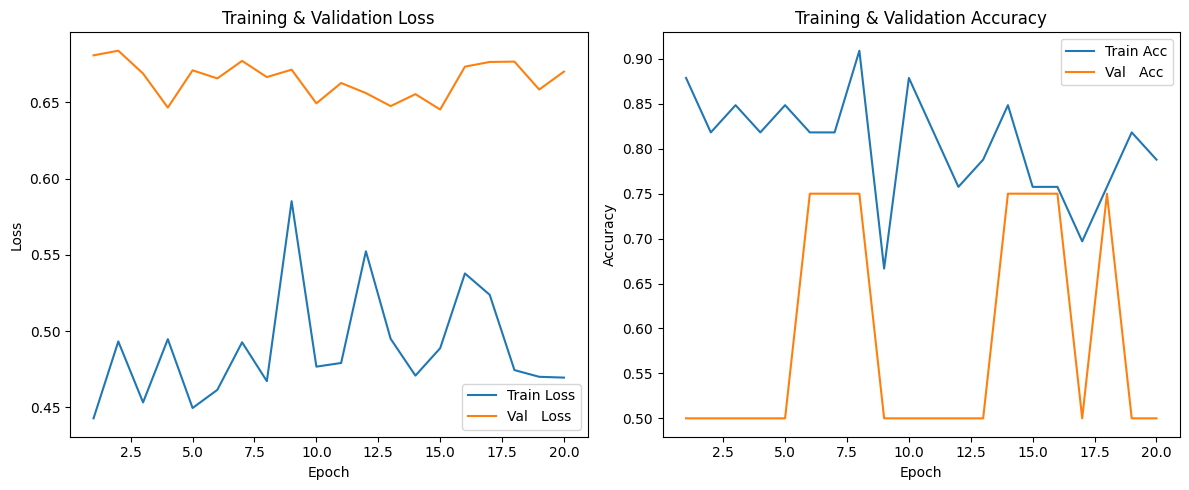


Final Epoch Validation Accuracy: 0.500
Best Validation Accuracy over all Epochs: 0.750
Best‐val model saved to: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Video\cnn_lstm_best_val.pth


In [15]:
#rain the Model (Training & Validation Loop)
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch

# (Assumes you are already in the "Video" folder or have set it via os.chdir if needed)

n_epochs = 20

# Lists to store losses and accuracies for plotting later
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Variables to track the best validation accuracy and the path to save that model
best_val_acc = 0.0
best_model_path = os.path.join(os.getcwd(), "cnn_lstm_best_val.pth")

for epoch in range(1, n_epochs + 1):
    # ---------------------------
    # 1) Training Step
    # ---------------------------
    model.train()
    running_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    
    for clips, labels in train_loader:
        clips = clips.to(device)        # (batch_size, 10, 3, 224, 224)
        labels = labels.to(device)      # (batch_size,)
        
        optimizer.zero_grad()
        outputs = model(clips)          # (batch_size, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * clips.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(labels.cpu().numpy())
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc  = accuracy_score(all_train_labels, all_train_preds)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # ---------------------------
    # 2) Validation Step
    # ---------------------------
    model.eval()
    running_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for clips, labels in val_loader:
            clips = clips.to(device)
            labels = labels.to(device)
            
            outputs = model(clips)       # (batch_size, 2)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * clips.size(0)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_val_preds.extend(preds)
            all_val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc  = accuracy_score(all_val_labels, all_val_preds)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # ---------------------------
    # Print epoch summary
    # ---------------------------
    print(
        f"Epoch {epoch}/{n_epochs}  "
        f"Train Loss: {epoch_train_loss:.4f}  Train Acc: {epoch_train_acc:.3f}  "
        f"Val   Loss: {epoch_val_loss:.4f}  Val   Acc: {epoch_val_acc:.3f}"
    )
    
    # ---------------------------
    # 3) Save model if this epoch has the best validation accuracy so far
    # ---------------------------
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)

# ---------------------------
# 4) Plot Loss & Accuracy Curves
# ---------------------------
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 5))

# a) Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# b) Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies,   label="Val   Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------
# 5) Print Final & Best Validation Accuracy
# ---------------------------
final_val_acc = val_accuracies[-1]
print(f"\nFinal Epoch Validation Accuracy: {final_val_acc:.3f}")
print(f"Best Validation Accuracy over all Epochs: {best_val_acc:.3f}")
print(f"Best‐val model saved to: {best_model_path}")

## Inference on TestSet: Visualise, Display & Save Results (Using Best‐Val Checkpoint)

This cell performs end-to-end inference on the videos in the `TestSet` folder, using the checkpoint with the highest validation accuracy. It displays the sampled frames with true and predicted labels inline, and saves each figure as both a page in a multi-page PDF and as individual PNG files. The steps are:

1. **Reload the Best‐Val Model**  
   - Instantiate the same `CNN_LSTM_Classifier` architecture.  
   - Load the checkpoint `cnn_lstm_best_val.pth` (the model weights that achieved the highest validation accuracy).  
   - Move the model to `device` (CPU or GPU) and set it to `eval()` mode.

2. **Build a DataFrame of Test Clips**  
   - Scan the folders `TestSet/Happy/` and `TestSet/Angry/` for any `.mp4` or `.avi` files.  
   - Create a DataFrame `df_testser` with two columns:  
     - `filepath`: full path to each video file (forward-slash formatted).  
     - `label`: `"happy"` or `"angry"`, inferred from the folder name.  
   - Print out the first few rows and class counts to confirm that all test videos have been located correctly.

3. **Define `VideoDatasetInference`**  
   - This dataset class mirrors our training-time `VideoDataset` but is used for inference. For each clip, it:  
     1. Opens the video with OpenCV.  
     2. Computes `total_frames` and `fps`.  
     3. Identifies the indices corresponding to the last 5 seconds (or the entire clip if it’s shorter).  
     4. Uniformly samples exactly 10 frames within that window.  
     5. Converts each BGR frame to RGB, wraps it as a PIL image, and applies the same `transform` (resize → 224×224 → normalise).  
     6. If fewer than 10 frames are read (e.g., clip < 10 frames or a read failure), pads by repeating the last valid frame.  
     7. Returns a tensor of shape `(10, 3, 224, 224)` plus the integer label index (`0` for “angry,” `1` for “happy”).

4. **Create the Inference Dataset & DataLoader**  
   - Instantiate `inference_dataset = VideoDatasetInference(df_testser, n_frames=10, sample_last_secs=5, transform=transform)`.  
   - Wrap it in a `DataLoader` with `batch_size=1` (to visualise each clip individually) and `num_workers=0` (to avoid multiprocessing issues).

5. **Prepare to Save Figures**  
   - Define `pdf_path = "test_results.pdf"` and create a folder `test_results_png/` to hold individual PNG exports.  
   - Open a `with PdfPages(pdf_path) as pdf:` context so that each call to `pdf.savefig(fig)` appends a new page.

6. **Loop Over Test Clips & Perform Inference**  
   - Disable gradient computation with `torch.no_grad()`.  
   - For each clip (batch size = 1):  
     1. Move the clip tensor (shape `(1, 10, 3, 224, 224)`) to `device`.  
     2. Look up the ground-truth label string (`true_label`) from `inference_dataset.labels`.  
     3. Forward-pass through the loaded best-val `model` to get `logits` of shape `(1, 2)`.  
     4. Compute `pred_label = inference_dataset.labels[logits.argmax(dim=1).item()]`.  
     5. Take the first 5 of the 10 sampled frames, un-normalise them (map pixel values back to `[0, 1]`) and plot them side by side in a single figure with `fig.suptitle(f"Clip {idx+1}: True={true_label.upper()} | Pred={pred_label.upper()}")`.  
     6. Call `plt.show()` to display the figure inline in the notebook.

7. **Save Each Figure**  
   - After displaying, call `pdf.savefig(fig)` to append the figure as a new page in `test_results.pdf`.  
   - Also save the figure as a PNG named  
     ```
     clip_{idx+1}_true_{true_label}_pred_{pred_label}.png
     ```  
     inside `test_results_png/`.  
   - Call `plt.close(fig)` to free memory.

8. **Final Printouts**  
   - After processing all clips, print:  
     ```
     Saved multi-page PDF: <full_path>/test_results.pdf  
     Saved individual PNGs in folder: <full_path>/test_results_png
     ```  
   - You can then send `test_results.pdf` (one page per clip) or the PNGs as part of your portfolio.

---

**Usage Notes:**  
- Ensure your directory structure is exactly:  

 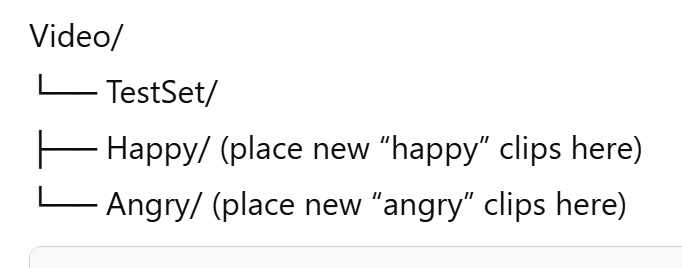

- Run this cell only after training, since it relies on `cnn_lstm_best_val.pth` having been saved.  


C:\Users\IAGhe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\IAGhe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DataFrame of new test clips:
                                            filepath  label
0  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
1  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
2  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
3  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy
4  C:/Users/IAGhe/OneDrive/Documents/Learning/por...  happy 

Counts per label:
label
angry    7
happy    6
Name: count, dtype: int64 



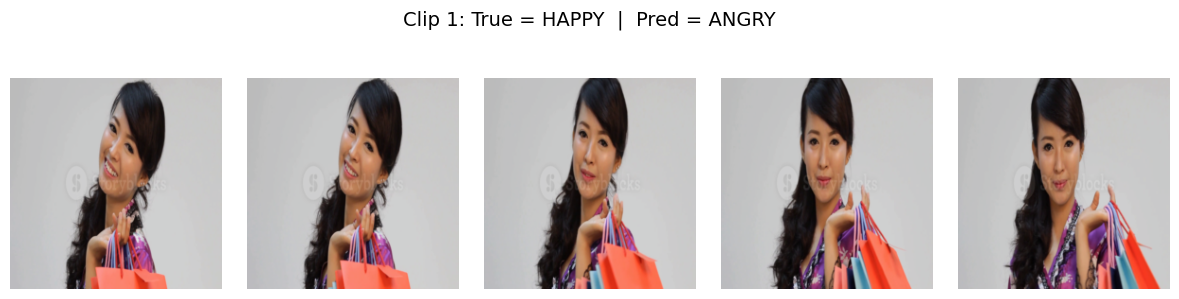

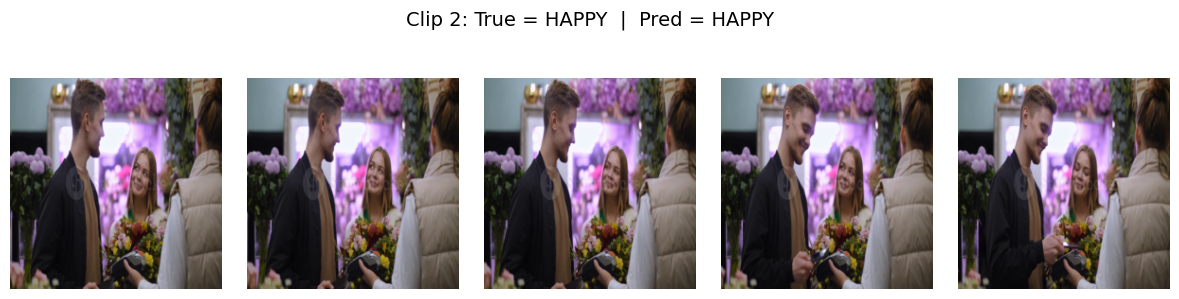

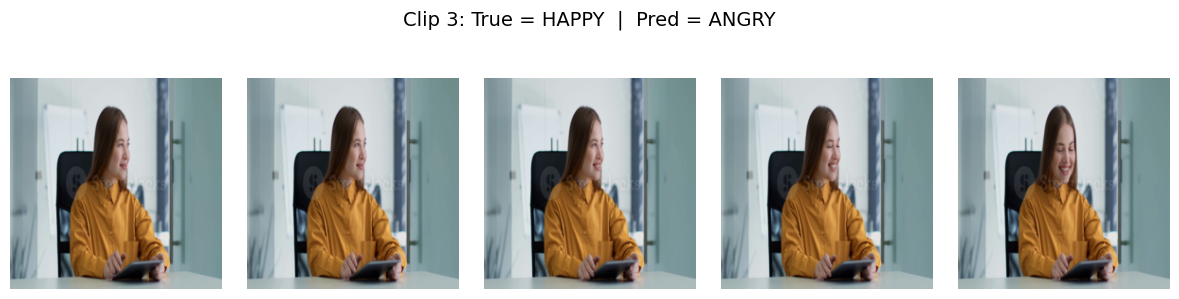

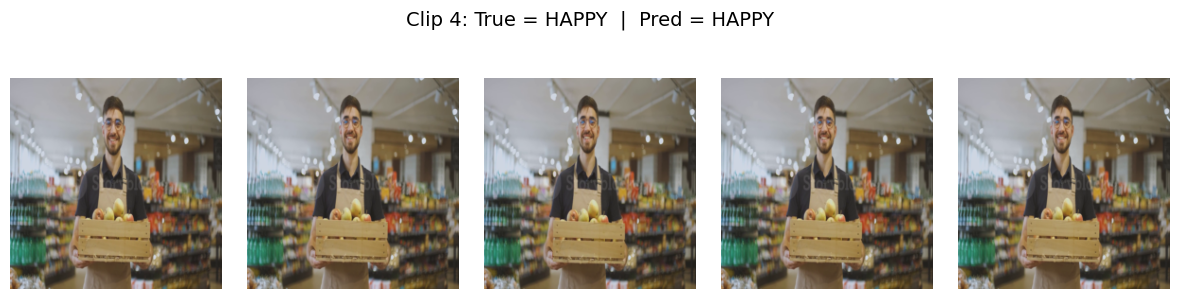

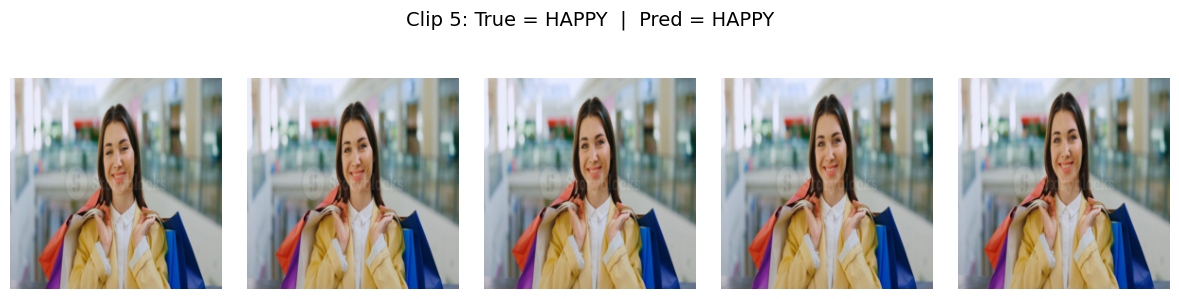

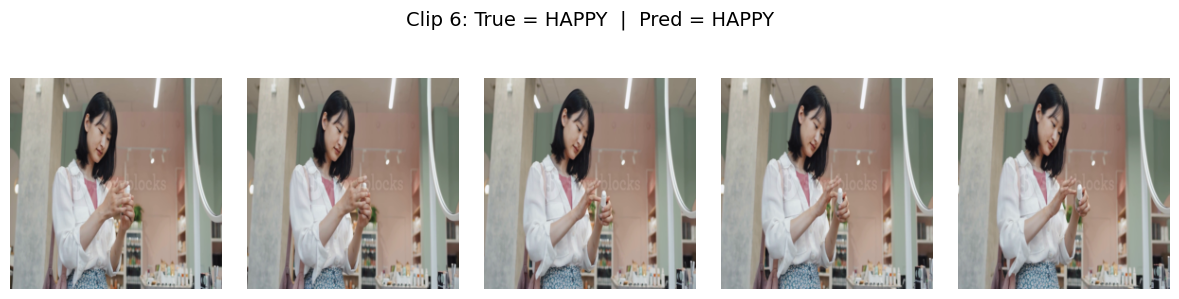

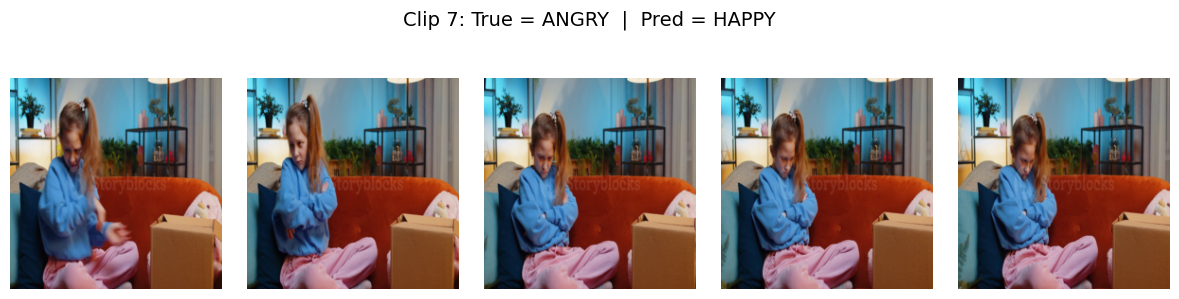

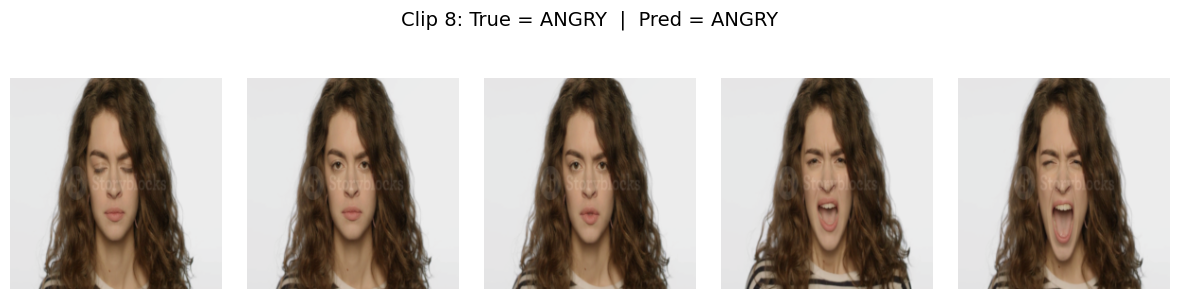

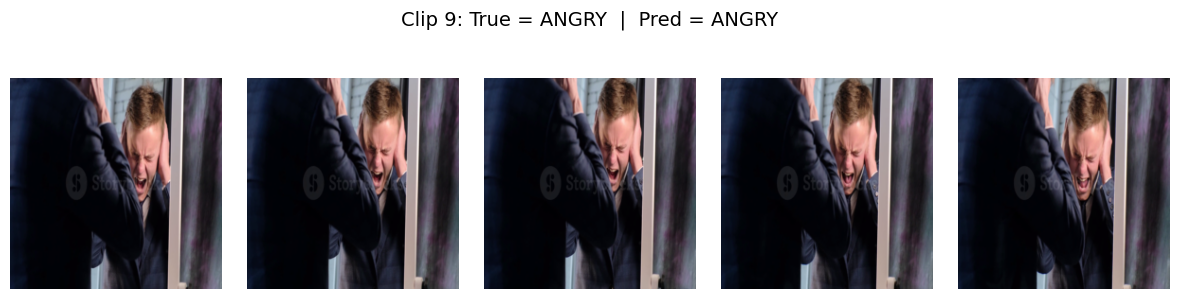

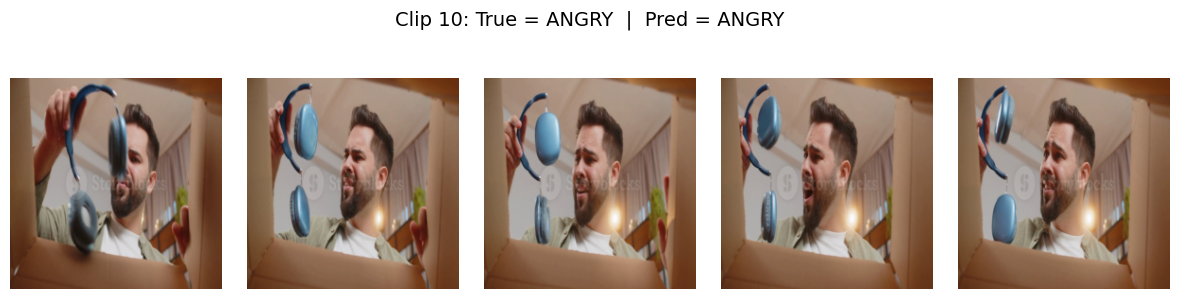

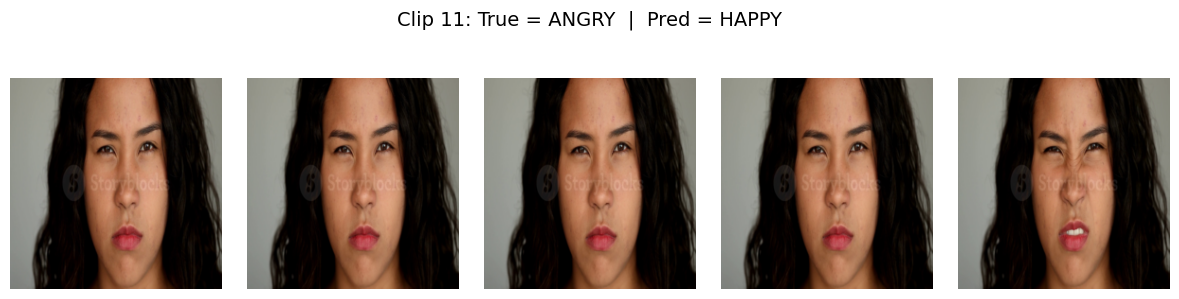

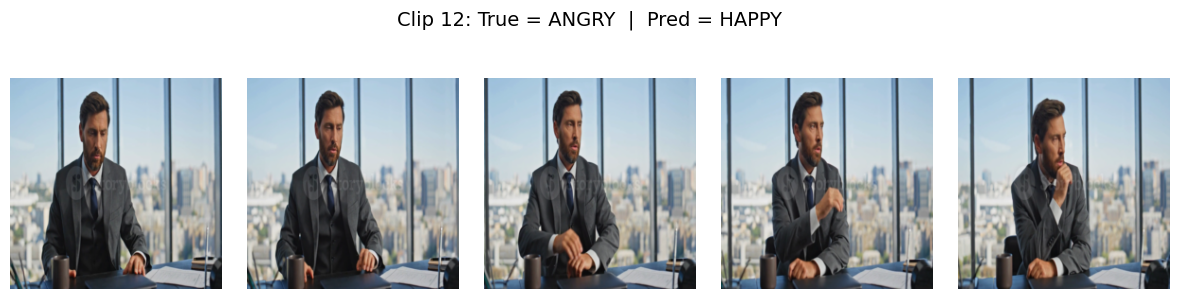

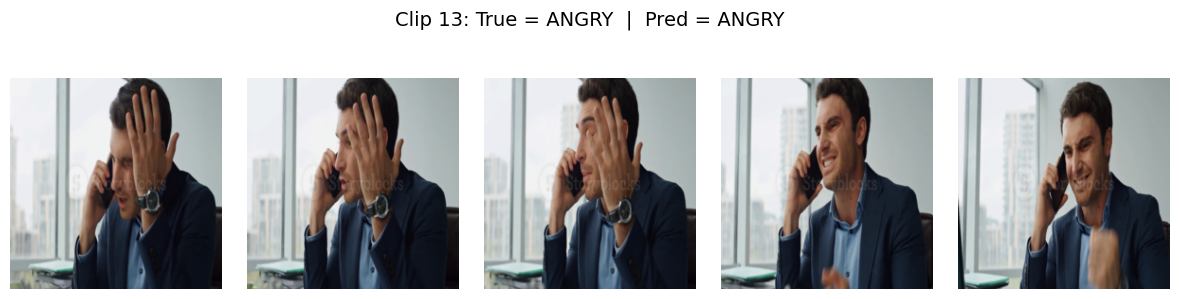

Saved multi-page PDF: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Video\test_results.pdf
Saved individual PNGs in folder: C:\Users\IAGhe\OneDrive\Documents\Learning\portfolio\Video\test_results_png


In [16]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell: Inference on TestSet Using Best‐Val Model, Visualise, Display & Save Figures
# ────────────────────────────────────────────────────────────────────────────────

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# 0. Reload the model architecture and load the best‐val checkpoint
# (Assumes CNN_LSTM_Classifier is already defined in this notebook)
best_model_path = os.path.join(os.getcwd(), "cnn_lstm_best_val.pth")
model = CNN_LSTM_Classifier(n_classes=2, hidden_dim=256, n_layers=1, pretrained=False)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# 1. Build a DataFrame by scanning TestSet/Happy and TestSet/Angry
base_test_folder = os.path.join(os.getcwd(), "TestSet")

rows = []
for label in ["Happy", "Angry"]:
    folder_path = os.path.join(base_test_folder, label)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"Expected folder not found: {folder_path}")
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith((".mp4", ".avi")):
            full_path = os.path.join(folder_path, fname).replace("\\", "/")
            rows.append({
                "filepath": full_path,
                "label": label.lower()  # "happy" or "angry"
            })

df_testser = pd.DataFrame(rows)
if df_testser.empty:
    raise RuntimeError("No video files found under TestSet/Happy or TestSet/Angry")

print("DataFrame of new test clips:")
print(df_testser.head(), "\n")
print("Counts per label:")
print(df_testser["label"].value_counts(), "\n")

# 2. Define the same VideoDataset logic (sampling last 5 seconds, 10 frames)
class VideoDatasetInference(Dataset):
    def __init__(self, df, n_frames=10, sample_last_secs=5, transform=None):
        self.df = df.reset_index(drop=True)
        self.n_frames = n_frames
        self.sample_last_secs = sample_last_secs
        self.transform = transform
        self.labels = sorted(self.df["label"].unique())
        self.label2idx = {lbl: idx for idx, lbl in enumerate(self.labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row["filepath"]
        label_str = row["label"]
        label_idx = self.label2idx[label_str]

        cap = cv2.VideoCapture(filepath)
        if not cap.isOpened():
            dummy = torch.zeros((self.n_frames, 3, 224, 224))
            return dummy, label_idx

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else 30.0
        window_len = int(fps * self.sample_last_secs)
        start_frame = max(0, total_frames - window_len)

        if total_frames > 0 and start_frame < total_frames:
            indices = np.linspace(start_frame, total_frames - 1, num=self.n_frames).astype(int)
        else:
            indices = np.zeros(self.n_frames, dtype=int)

        frames = []
        for fid in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fid))
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame_rgb)
            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.ToTensor()(img)
            frames.append(img)

        cap.release()

        if len(frames) == 0:
            dummy = torch.zeros((self.n_frames, 3, 224, 224))
            return dummy, label_idx

        while len(frames) < self.n_frames:
            frames.append(frames[-1].clone())

        clip_tensor = torch.stack(frames, dim=0)
        return clip_tensor, label_idx

# 3. Re‐use the same transform from training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# 4. Create the inference dataset and loader (batch_size=1 for easy visualization)
inference_dataset = VideoDatasetInference(df_testser, n_frames=10, sample_last_secs=5, transform=transform)
inference_loader  = DataLoader(inference_dataset, batch_size=1, shuffle=False, num_workers=0)

# 5. Prepare to save plots into a multi-page PDF and individual PNGs
pdf_path = os.path.join(os.getcwd(), "test_results.pdf")
png_folder = os.path.join(os.getcwd(), "test_results_png")
os.makedirs(png_folder, exist_ok=True)

with PdfPages(pdf_path) as pdf:
    with torch.no_grad():
        for idx, (clip_tensor, label_idx) in enumerate(inference_loader):
            # Move to device
            clip_tensor = clip_tensor.to(device)   # (1, 10, 3, 224, 224)
            true_label = inference_dataset.labels[label_idx.item()]

            # Forward pass
            logits = model(clip_tensor)            # (1, 2)
            pred_idx = logits.argmax(dim=1).item()
            pred_label = inference_dataset.labels[pred_idx]

            # Take the first 5 of the 10 sampled frames for display
            frames = clip_tensor.cpu().squeeze(0)   # (10, 3, 224, 224)
            n_plot = min(5, frames.shape[0])

            # Create a new figure for this clip
            fig = plt.figure(figsize=(12, 3))
            for j in range(n_plot):
                frame_j = frames[j].permute(1, 2, 0).numpy()
                # Un‐normalize
                frame_j = (frame_j * np.array([0.229, 0.224, 0.225]) +
                           np.array([0.485, 0.456, 0.406]))
                frame_j = np.clip(frame_j, 0, 1)

                ax = plt.subplot(1, n_plot, j + 1)
                ax.imshow(frame_j)
                ax.axis("off")

            title = f"Clip {idx + 1}: True = {true_label.upper()}  |  Pred = {pred_label.upper()}"
            fig.suptitle(title, fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.92])

            # Display the figure inline
            plt.show()

            # Save the figure into the PDF (one page per clip)
            pdf.savefig(fig)

            # Also save as a PNG for each clip
            png_filename = f"clip_{idx+1}_true_{true_label}_pred_{pred_label}.png"
            png_path = os.path.join(png_folder, png_filename)
            fig.savefig(png_path)

            # Close the figure to free memory
            plt.close(fig)

print(f"Saved multi-page PDF: {pdf_path}")
print(f"Saved individual PNGs in folder: {png_folder}")
